---

# Mastère Spécialisé Expert en Science des données

---
## MACHINE LEARNING 2
---

*Auteur :* Paquarse Mahouvi

*Date:* 05-01-2024
---

# Importation des packages et définitions des fonctions d'affichages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import scipy.io as sio
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
import warnings
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

plt.close("all")

def plot_decision_margin_2d(X, y, classifier, resolution=0.02, titre=''): 
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0, X[:, 0].max() + 0
    x2_min, x2_max = X[:, 1].min() - 0, X[:, 1].max() + 0
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # margin
    Z = classifier.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    cs = plt.contour(xx1, xx2, Z, levels=[-1, 0, 1], colors=['r', 'g', 'b'], linewidths=2.5)
    plt.clabel(cs)
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.6, c=cmap(idx),
                    marker=markers[idx], label= 'classe {}'.format(cl))
    plt.legend(loc='best')
    plt.title(titre, fontsize=12)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Partie 1 : SVM Linéaire 
## Prise en main 
### Importation des données 

-   Donnees apprentissage

In [40]:
data_a = sio.loadmat('/kaggle/input/mixture/mixtureexampleTRAIN.mat')
Xa, Ya = data_a['Xa'], data_a['Ya'][:,0]
print('\nCaractéristiques jeu apprentissage : ')
print('Nombre de points : {}'.format(Xa.shape[0]))
print('Nombre de variables : {}'.format(Xa.shape[1]))
print('Nombre de classes : {}'.format(len(np.unique(Ya))))
classes, nbpoints = np.unique(Ya, return_counts=True)
for i, lab in enumerate(classes):
    print('Classe {} comprend {} points'.format(lab, nbpoints[i]))


Caractéristiques jeu apprentissage : 
Nombre de points : 1000
Nombre de variables : 2
Nombre de classes : 2
Classe -1 comprend 457 points
Classe 1 comprend 543 points


-   Donnees test

In [41]:
data_t = sio.loadmat('/kaggle/input/mixture/mixtureexampleTEST.mat')
Xt, Yt = data_t['Xt'], data_t['Yt'][:,0]
print('\nCaractéristiques jeu de test : ')
classes, nbpoints = np.unique(Yt, return_counts=True)
for i, lab in enumerate(classes):
    print('Classe {} comprend {} points'.format(lab, nbpoints[i]))


Caractéristiques jeu de test : 
Classe -1 comprend 94 points
Classe 1 comprend 107 points


On peut remarquer que la variable d'intérêt de notre jeu de données contient deux classes (modalités) -1 et 1. 

### Mise en place de l'échantillon de validation

Notre échantillon d'apprentissage sera séparé en deux. Un échnatillon d'apprentissage et un échantillon de test. Dans le but de permettre au modèle d'apprendre sur beaucoup plus de données, l'échantillon d'apprentissage contiendra plus de données que l'échantillon de validation. Par la suite, les données seront donc normaliser. 

In [42]:
Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, shuffle=True, test_size=0.2, stratify=Ya)

In [43]:
sc = StandardScaler(with_mean=True, with_std=True)
sc = sc.fit(Xa)
Xa = sc.transform(Xa)
Xv = sc.transform(Xv)
Xt = sc.transform(Xt)

### Mise en place de SVM avec un paramètre choisi (C= 1)

In [44]:
paramC = 1
clf_svm = SVC(kernel='linear', C = paramC)
# apprentissage des parametres du SVM Lineaire sur le jeu d'apprentissage
clf_svm.fit(Xa, Ya)

SVC(C=1, kernel='linear')

### La frontière des décisions

/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


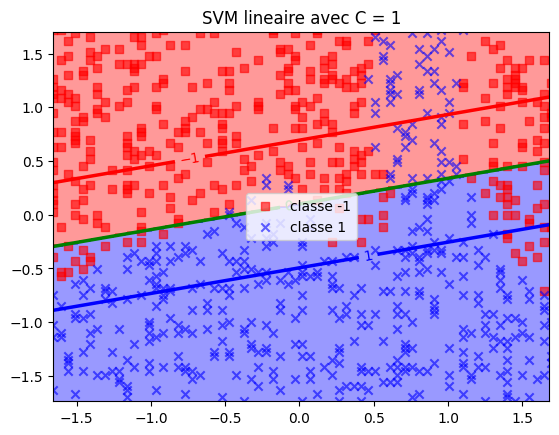

In [45]:
#%% Trace de la frontiere de decision et de la marge 
plot_decision_margin_2d(Xa, Ya, clf_svm, 0.02, titre='{} avec C = {}'.format("SVM lineaire", paramC))

La frontière des décisions permet de mettre en évidence l'incapacité du modèle SVM à séparer linéairement tous les éléments des deux classes. On peut remarquer qu'une frontière de décision linéaire n'est pas forcément la meilleure pour la séparation des données, comme en témoigne la rangée de bleu pouvant être séparé par des traits verticaux.

### Les erreurs de classification sur l'échantillon test du modèle SVM

In [46]:
err_app = 1 - accuracy_score(Ya, clf_svm.predict(Xa))
print('\nSVM Lineaire : erreur apprentissage = {}'.format(err_app))
err_test = 1 - accuracy_score(Yt, clf_svm.predict(Xt))
print('SVM Lineaire : erreur test = {}'.format(err_test))


SVM Lineaire : erreur apprentissage = 0.14749999999999996
SVM Lineaire : erreur test = 0.17412935323383083


Nous pouvons observé que les erreurs d'apprentissage et de test sont relativement proches et pas très élevés. On peut donc en conclure que que ce modèle permet de bien classé près de 85% des données de l'échantillon test, une performance dont beaucoup diront qu'elle n'est pas si mauvaise. Toutefois, la frontière de décision montre que la séparation linéaire n'est pas adapté aux données. Toutefois, une autre marge serait-elle plus adaptée pour une sépération linéaire ?

### Fonctionnement de la frontière de décision et la marge  

On va choisir différentes valeurs du paramètre de régularisation C. L'intensité de la régularisation est inversement proportionnelle à C. Elle doit être strictement positive. Nous observerons donc la frontière de décision pour les différentes valeurs de la marge.

/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedenc

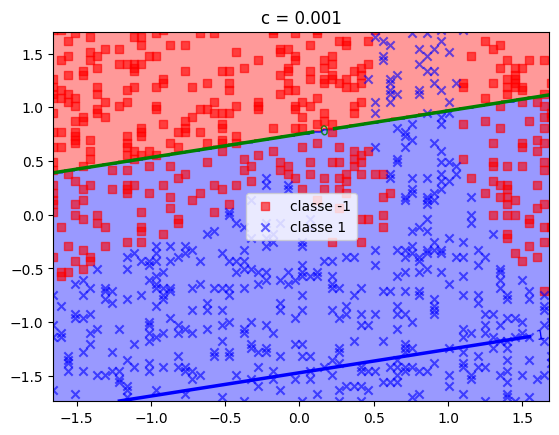

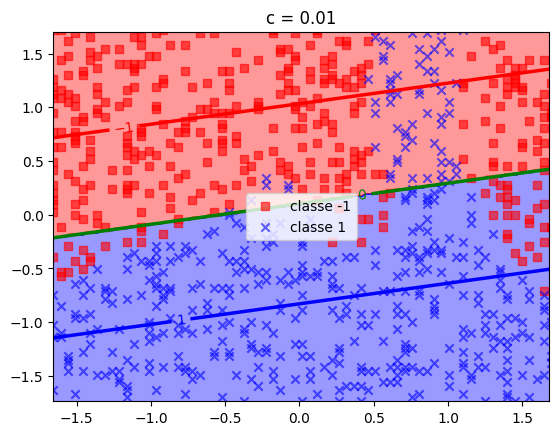

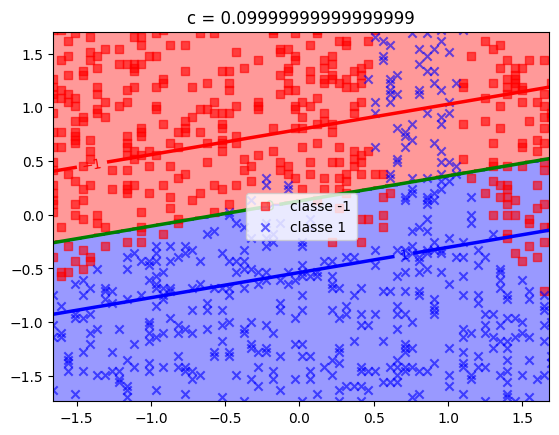

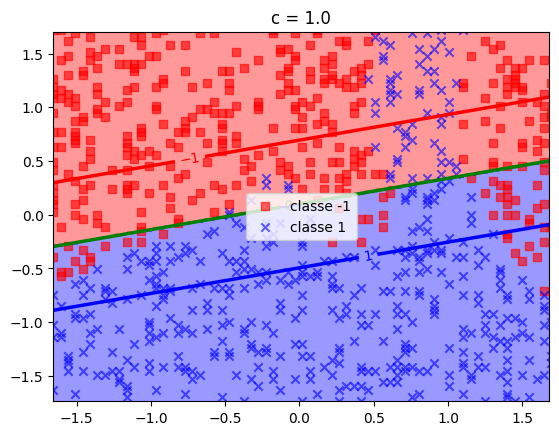

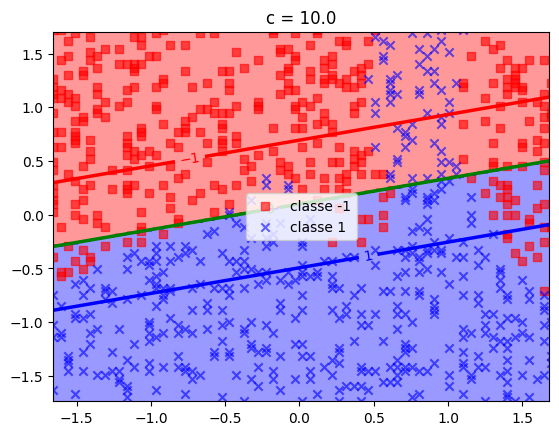

In [47]:
vectC = np.logspace(-3, 1, 5)
for paramC in vectC:
    clf_svm.C = paramC
    clf_svm.fit(Xa, Ya)
    plot_decision_margin_2d(Xa, Ya, clf_svm, 0.02, titre="c = {}".format(paramC))

A la vue des différents graphiques, on peut observer que plus c est petit plus, plus la marge est grande. Et pour rappelle, l'intensité de la régularisation est inversement proportionnelle à C. Il serait donc intéressant de voir pour les différentes valeurs de C l'erreur de classification sur l'échantillon test.

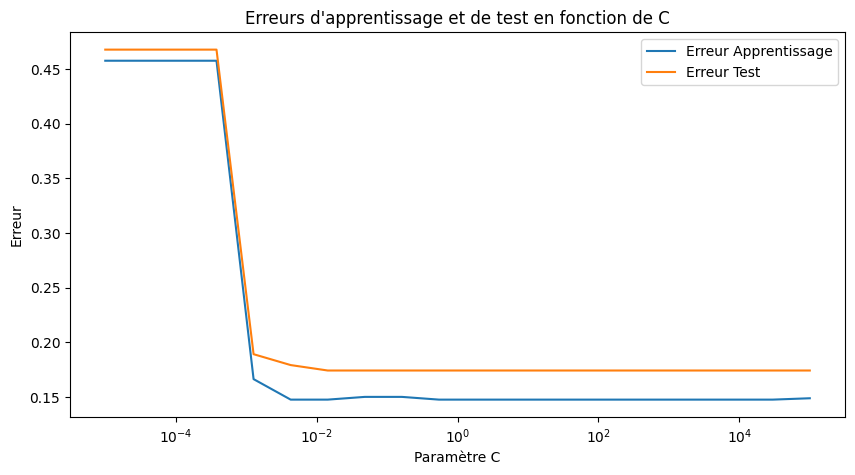

In [48]:
# Tableau des données
df_results = pd.DataFrame(columns=['Paramètre C', 'Erreur Apprentissage', 'Erreur Test'])

# Valeurs de C
parametres_C = np.logspace(-5, 5, 20)

for parC in parametres_C:
    clf_svm_C = SVC(kernel='linear', C=parC)
    clf_svm_C.fit(Xa, Ya)
    
    # Calculer les erreurs d'apprentissage et de test
    err_app_c = 1 - accuracy_score(Ya, clf_svm_C.predict(Xa))
    err_test_c = 1 - accuracy_score(Yt, clf_svm_C.predict(Xt))
    
    # Ajouter les résultats au DataFrame
    df_results.loc[len(df_results)] = [parC, err_app_c, err_test_c]
    

plt.figure(figsize=(10, 5))
plt.plot(df_results['Paramètre C'], df_results['Erreur Apprentissage'], label='Erreur Apprentissage')
plt.plot(df_results['Paramètre C'], df_results['Erreur Test'], label='Erreur Test')
plt.xscale('log')  # Mettre l'échelle de C en log
plt.xlabel('Paramètre C')
plt.ylabel('Erreur')
plt.title('Erreurs d\'apprentissage et de test en fonction de C')
plt.legend()
plt.show()

Ce graphique permet de mettre en évidence l'influence du paramètre C sur les erreurs d'échantillonage et de test. Pour différentes valeurs de C, les erreurs ne sont pas les mêmes. Le choix de ce paramètre influence donc les performances de notre modèle. 

### Choix du meilleur paramètre C

Comme montrer précédemment le choix de ce paramètre à une influence sur la performances des modèles


 C optimal = 0.011787686347935873


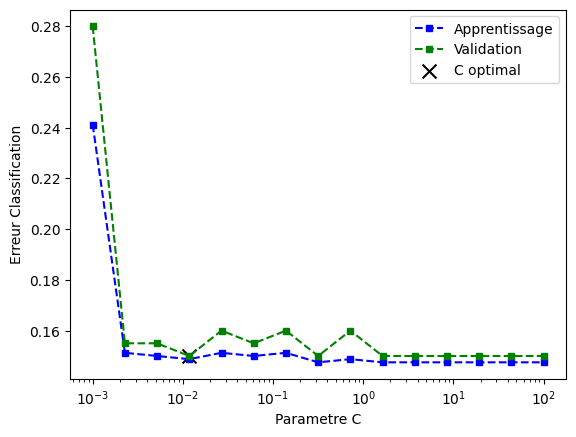

In [49]:
# Choix du C optimal par validation croisee
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(Xa, Ya)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(Yv, clf_svm.predict(Xv))
    err_app[ind_C] = 1 - accuracy_score(Ya, clf_svm.predict(Xa))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.scatter(Copt, err_min_val, color='black', marker='x', s=100, label='C optimal')
plt.legend()
plt.show()

On peut observé que le C optimal obtenu sur l'échantillon de validation est de 0.01

### Évaluer le modèle optimal correspondant à C* sur les données apprentissage et test

In [50]:
# Apprentissage modele optimal et evaluation
clf_svm.C = Copt
clf_svm.fit(Xa, Ya)
err_app = 1 - accuracy_score(Ya, clf_svm.predict(Xa))
print("\nSVM Lineaire optimal : erreur apprentissage = {}".format(err_app))
err_test = 1 - accuracy_score(Yt, clf_svm.predict(Xt))
print("SVM Lineaire optimal : erreur test = {}".format(err_test))
err_val = 1 - accuracy_score(Yv, clf_svm.predict(Xv))
print("SVM Lineaire optimal : erreur validation = {}".format(err_val))


SVM Lineaire optimal : erreur apprentissage = 0.14875000000000005
SVM Lineaire optimal : erreur test = 0.17412935323383083
SVM Lineaire optimal : erreur validation = 0.15000000000000002


On peut noter que l'erreur d'apprentissage est l'une des erreurs qu'on a trouvé pour les différentes valeurs de C. Ce C optimal pourra être utilisé pour avoir de petites erreurs. 

- Résumé du modèle linéaire sur Mixture
  
|Indicateur              | Modèle SVM Linéaire |
|------------------------|---------------------|
| Erreur Apprentissage   | 0.14                |
| Erreur Validation      | 0.18                |
| Erreur Test            | 0.15                |

## Extension aux données CTG et Mnist

### Données CTG

#### Modèle logistique

In [51]:
# Chargement des données
#df = pd.read_csv("./CTGSimple.csv", sep="\t",header=1)
df = pd.read_csv("/kaggle/input/ctg-data/CTGSimple.csv", sep="\t",header=1)
Y = df["NSP"].values
variables = ["LB","AC.1","FM.1","UC.1","DL.1","DS.1","DP.1","ASTV","MSTV","ALTV","MLTV", "Width","Min","Max","Nmax", "Nzeros","Mode","Mean","Median","Variance","Tendency"]
X = df[variables].values
df.shape

# Regroupement en deux classes
classe = 3
Y[np.in1d(Y, classe)] = 2

# Echantillon d'apprentissage-Validation-Test
Xa, Xt, Ya, Yt = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y)
Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, shuffle=True, test_size = 0.2 / (1 - 0.2), stratify=Ya)

# Normalisation des données
sc = StandardScaler(with_mean=True, with_std=True)
sc = sc.fit(Xa)
Xa = sc.transform(Xa)
Xv = sc.transform(Xv)
Xt = sc.transform(Xt)

In [52]:
# Selection de l'hyper-parametre C 
ctg_reglog = linear_model.LogisticRegression(tol=1e-5, multi_class='multinomial', solver='lbfgs')
# Vecteur des possibles de C
vectC = np.logspace(-3, 2, 100)
# Erreur aléatoire à changer par les bonnes valeurs
err_app = np.empty(vectC.shape[0])
err_val = np.empty(vectC.shape[0])
for ind_C, C in enumerate(vectC):
    ctg_reglog.C = C
    ctg_reglog.fit(Xa, Ya)
    # Calcul des erreurs apprentissage et de test
    err_val[ind_C] = 1 - accuracy_score(Yv, ctg_reglog.predict(Xv))
    err_app[ind_C] = 1 - accuracy_score(Ya, ctg_reglog.predict(Xa))

In [53]:
# Choix du meilleur C
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]

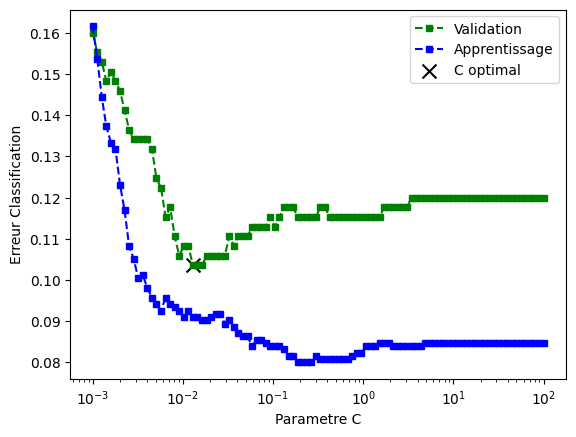

In [54]:
# Trace des courbes d'erreur d'apprentissage
plt.figure()
plt.semilogx(vectC, err_val, color='green', linestyle='--', marker='s', markersize=5, label='Validation')
plt.semilogx(vectC, err_app, color='blue', linestyle='--', marker='s', markersize=5, label='Apprentissage')
plt.xlabel('Parametre C')
plt.ylabel('Erreur Classification')
plt.legend(loc='best')
plt.scatter(Copt, err_min_val, color='black', marker='x', s=100, label='C optimal')
plt.legend()
plt.show()

In [55]:
# Model final
ctg_reglog.C = Copt
ctg_reglog.fit(Xa, Ya)
print('Valeur de Copt = {}'.format(Copt))
print('Erreur validation correspondante = {}'.format(100*(1 - accuracy_score(Yv, ctg_reglog.predict(Xv)))))
print('Erreur apprentissage correspondante = {}'.format(100*(1 - accuracy_score(Ya, ctg_reglog.predict(Xa)))))

Valeur de Copt = 0.01291549665014884
Erreur validation correspondante = 10.352941176470587
Erreur apprentissage correspondante = 9.09803921568627


Le taux de mauvais classement est : 9.859154929577462


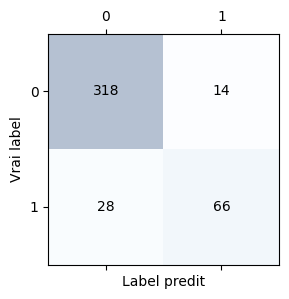

In [56]:
log_y_pred = ctg_reglog.predict(Xt)
confmat = confusion_matrix(y_true=Yt, y_pred=log_y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
plt.xlabel("Label predit")
plt.ylabel("Vrai label")
print("Le taux de mauvais classement est :", (1-accuracy_score(y_true=Yt, y_pred=log_y_pred))*100)

Il est important que les performances changent en fonction de l'échantillon

#### Modèle SVM 
On réaliser le SVM avec un paramètre C optimisé afin d'être le plus "fair-play" possible dans la comparaison des performances

In [59]:
cgt_svm = SVC(kernel='linear')
vectC = np.logspace(-3, 2, 100)
err_app_svm_cgt = np.empty(vectC.shape[0])
err_val_svm_cgt = np.empty(vectC.shape[0])

for ind_C, C_svm in enumerate(vectC):
    cgt_svm.C = C_svm
    cgt_svm.fit(Xa, Ya)
    
    # Calcul des erreurs d'apprentissage et de validation
    err_val_svm_cgt[ind_C] = 1 - accuracy_score(Yv, cgt_svm.predict(Xv))
    err_app_svm_cgt[ind_C] = 1 - accuracy_score(Ya, cgt_svm.predict(Xa))

In [60]:
# Choix du meilleur C
err_min_val, ind_min = err_val_svm_cgt.min(), err_val_svm_cgt.argmin()
Copt_cgt_svm = vectC[ind_min]

In [61]:
# Model final
cgt_svm.C = Copt_cgt_svm
cgt_svm.fit(Xa, Ya)

print('Valeur de Copt = {}'.format(Copt_cgt_svm))
print('Erreur validation correspondante = {}'.format(100*(1 - accuracy_score(Yv, cgt_svm.predict(Xv)))))
print('Erreur apprentissage correspondante = {}'.format(100*(1 - accuracy_score(Ya, cgt_svm.predict(Xa)))))

Valeur de Copt = 0.016297508346206444
Erreur validation correspondante = 10.352941176470587
Erreur apprentissage correspondante = 9.490196078431367


Le taux de mauvais classement est : 10.563380281690138


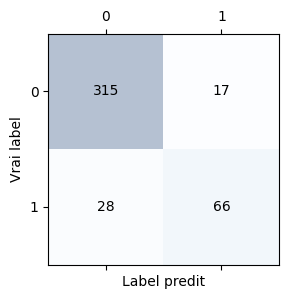

In [62]:
cgt_ytest_pred = cgt_svm.predict(Xt)
confmat_cgt = confusion_matrix(y_true=Yt, y_pred=cgt_ytest_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat_cgt, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_cgt.shape[0]):
    for j in range(confmat_cgt.shape[1]):
        ax.text(x=j, y=i, s=confmat_cgt[i, j], va="center", ha="center")
plt.xlabel("Label predit")
plt.ylabel("Vrai label")
print("Le taux de mauvais classement est :", (1-accuracy_score(y_true=Yt, y_pred=cgt_ytest_pred))*100)

Le modèle SVM donne un taux de mauvais classement de 10,3%.Toutefois, il est important de remarquer que les taux changent en fonction des échantillon

Résumé modèle sur CTG

| Indicateur            | logistic | SVM Linéaire |
|-----------------------|----------|--------------|
|Erreur apprentissage   | 9.09     | 9.49         |
|Erreur validation      | 10.35    | 10.35        |
|Erreur test            | 9.85     | 10.56        |

In [99]:
def Many_logistic(nombre, X, Y):
    Liste = []
    for i in range(nombre):
        un_random = np.random.randint(1, nombre*nombre)
        
        Xa, Xt, Ya, Yt = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=un_random)
        Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, shuffle=True, test_size=0.2 / (1 - 0.2), stratify=Ya, random_state=un_random)
        
        # Normalisation
        sc = StandardScaler(with_mean=True, with_std=True)
        sc = sc.fit(Xa)
        Xa = sc.transform(Xa)
        Xv = sc.transform(Xv)
        Xt = sc.transform(Xt)
        
        # Regression
        ctg_reglog = linear_model.LogisticRegression(tol=1e-5, multi_class='multinomial', solver='lbfgs')
        # Vecteur des possibles de C
        vectC = np.logspace(-3, 2, 100)
        # Erreur aléatoire à changer par les bonnes valeurs
        err_app = np.empty(vectC.shape[0])
        err_val = np.empty(vectC.shape[0])
        
        for ind_C, C in enumerate(vectC):
            ctg_reglog.C = C
            ctg_reglog.fit(Xa, Ya)
            # Calcul des erreurs apprentissage et de test
            err_val[ind_C] = 1 - accuracy_score(Yv, ctg_reglog.predict(Xv))
            err_app[ind_C] = 1 - accuracy_score(Ya, ctg_reglog.predict(Xa))
            
        # Choix du meilleur C
        err_min_val, ind_min = err_val.min(), err_val.argmin()
        Copt = vectC[ind_min]
        
        # Model final
        ctg_reglog.C = Copt
        ctg_reglog.fit(Xa, Ya)

        # Prévision 
        y_predict = ctg_reglog.predict(Xt)
        accuracy = accuracy_score(y_true=Yt, y_pred=y_predict)
        Liste.append(accuracy)
    
    return Liste

In [100]:
cinquante_logistic_cgt = Many_logistic(50, X = X, Y = Y)

In [102]:
def Many_SVM(nombre, X, Y):
    Liste = []
    for i in range(nombre):
        un_random = np.random.randint(1, nombre*nombre)
        
        Xa, Xt, Ya, Yt = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=un_random)
        Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, shuffle=True, test_size=0.2 / (1 - 0.2), stratify=Ya, random_state=un_random)
        
        # Normalisation
        sc = StandardScaler(with_mean=True, with_std=True)
        sc = sc.fit(Xa)
        Xa = sc.transform(Xa)
        Xv = sc.transform(Xv)
        Xt = sc.transform(Xt)
        
        # Regression
        cgt_svm = SVC(kernel='linear')
        vectC = np.logspace(-3, 2, 100)
        err_app_svm_cgt = np.empty(vectC.shape[0])
        err_val_svm_cgt = np.empty(vectC.shape[0])
        
        for ind_C, C_svm in enumerate(vectC):
            cgt_svm.C = C_svm
            cgt_svm.fit(Xa, Ya)

            # Calcul des erreurs d'apprentissage et de validation
            err_val_svm_cgt[ind_C] = 1 - accuracy_score(Yv, cgt_svm.predict(Xv))
            err_app_svm_cgt[ind_C] = 1 - accuracy_score(Ya, cgt_svm.predict(Xa))
            
        # Choix du meilleur C
        err_min_val, ind_min = err_val_svm_cgt.min(), err_val_svm_cgt.argmin()
        Copt_cgt_svm = vectC[ind_min]
        
        # Model final
        cgt_svm.C = Copt_cgt_svm
        cgt_svm.fit(Xa, Ya)

        # Prévision 
        y_predict = cgt_svm.predict(Xt)
        accuracy = accuracy_score(y_true=Yt, y_pred=y_predict)
        Liste.append(accuracy)
    
    return Liste

In [103]:
cinquante_svm_cgt = Many_SVM(50, X = X, Y = Y)

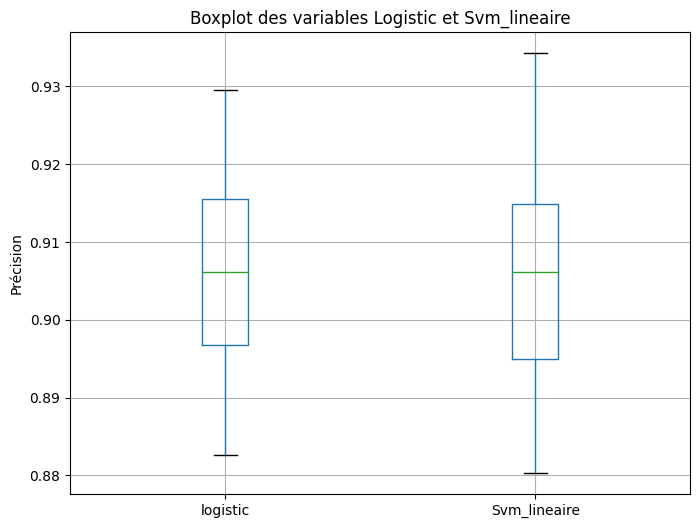

In [113]:
CGT = pd.DataFrame({"logistic":cinquante_logistic_cgt, "Svm_lineaire":cinquante_svm_cgt})
plt.figure(figsize=(8, 6))
CGT.boxplot(column=['logistic', 'Svm_lineaire'])
plt.title('Boxplot des variables Logistic et Svm_lineaire')
plt.ylabel('Précision')
plt.show()

De l'analyse des boites à moustache, on peut remarquer que sur les données CGT, les deux modèles ont à peu près les mêmes performances bien que l'étendue des performances des modèles svm soit plus grand

### Données Mnist

In [126]:
import scipy.io as sio
# Chargement des donnees
#digits_app = sio.loadmat("mnist-app.mat")
digits_app = sio.loadmat("/kaggle/input/mnist-data/mnist-app.mat")
Xa, Ya = digits_app["Xa"], digits_app["Ya"][:,0]
Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, shuffle=True, test_size = 0.2, stratify=Ya)

#digits_test = sio.loadmat("mnist-test.mat")
digits_test = sio.loadmat("/kaggle/input/mnist-data/mnist-test.mat")
Xt, Yt = digits_test["Xt"], digits_test["Yt"][:,0]

# Filtre les données ayant de faible variance
tol = 1e-3
stda = np.std(Xa, 0)
idx_var = np.squeeze(np.where(stda > tol))
Xa = Xa[:, idx_var]
Xv = Xv[:, idx_var]
Xt = Xt[:, idx_var]

# Normalisation des données
sc = StandardScaler(with_mean=True, with_std=True)
sc = sc.fit(Xa)
Xa = sc.transform(Xa)
Xv = sc.transform(Xv)
Xt = sc.transform(Xt)

#### Modèle Logistique

In [118]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Selection de l'hyper-parametre C 
mnist_reglog = linear_model.LogisticRegression(tol=1e-5, multi_class='multinomial', solver='lbfgs')
# Vecteur des possibles de C
vectC = np.logspace(-3, 2, 10)
# Erreur aléatoire à changer par les bonnes valeurs
err_app = np.empty(vectC.shape[0])
err_val = np.empty(vectC.shape[0])
for ind_C, C in enumerate(vectC):
    mnist_reglog.C = C
    mnist_reglog.fit(Xa, Ya)
    # Calcul des erreurs apprentissage et de test
    err_val[ind_C] = 1 - accuracy_score(Yv, mnist_reglog.predict(Xv))
    err_app[ind_C] = 1 - accuracy_score(Ya, mnist_reglog.predict(Xa))

In [119]:
# Choix du meilleur C
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]

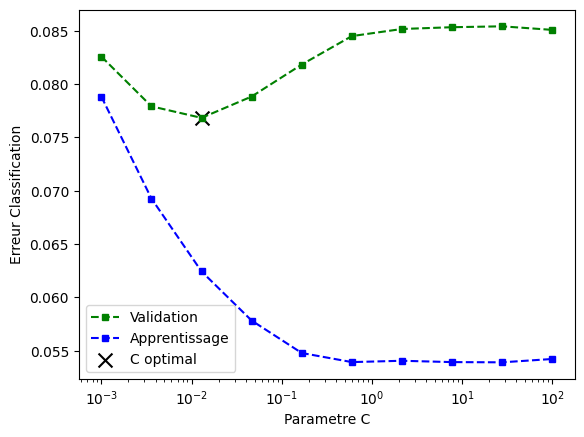

In [120]:
# Trace des courbes d'erreur d'apprentissage
plt.figure()
plt.semilogx(vectC, err_val, color='green', linestyle='--', marker='s', markersize=5, label='Validation')
plt.semilogx(vectC, err_app, color='blue', linestyle='--', marker='s', markersize=5, label='Apprentissage')
plt.xlabel('Parametre C')
plt.ylabel('Erreur Classification')
plt.legend(loc='best')
plt.scatter(Copt, err_min_val, color='black', marker='x', s=100, label='C optimal')
plt.legend()
plt.show()

In [122]:
# Model final
mnist_reglog.C = Copt
mnist_reglog.fit(Xa, Ya)
print('Valeur de Copt = {}'.format(Copt))
print('Erreur validation correspondante = {}'.format(100*(1 - accuracy_score(Yv, mnist_reglog.predict(Xv)))))
print('Erreur apprentissage correspondante = {}'.format(100*(1 - accuracy_score(Ya, mnist_reglog.predict(Xa)))))
print('Erreur test = {}'.format(100*(1 - accuracy_score(Yt, mnist_reglog.predict(Xt)))))

Valeur de Copt = 0.01291549665014884
Erreur validation correspondante = 7.683333333333331
Erreur apprentissage correspondante = 6.243750000000004
Erreur test = 7.369999999999999


#### Modèle SVM 
On réaliser le SVM avec un paramètre C choisir au hasard pour comparer les performances

In [127]:
mnist_svm = SVC(kernel='linear')
vectC = np.logspace(-3, 2, 2)
err_app_svm_mnist = np.empty(vectC.shape[0])
err_val_svm_mnist = np.empty(vectC.shape[0])

for ind_C, C_svm in enumerate(vectC):
    cgt_svm.C = C_svm
    mnist_svm.fit(Xa, Ya)
    
    # Calcul des erreurs d'apprentissage et de validation
    err_val_svm_mnist[ind_C] = 1 - accuracy_score(Yv, mnist_svm.predict(Xv))
    err_app_svm_mnist[ind_C] = 1 - accuracy_score(Ya, mnist_svm.predict(Xa))

In [128]:
# Choix du meilleur C
err_min_val, ind_min = err_val_svm_mnist.min(), err_val_svm_mnist.argmin()
Copt_mnist_svm = vectC[ind_min]

In [129]:
# Model final
mnist_svm.C = Copt_mnist_svm
mnist_svm.fit(Xa, Ya)

print('Valeur de Copt = {}'.format(Copt_mnist_svm))
print('Erreur validation correspondante = {}'.format(100*(1 - accuracy_score(Yv, mnist_svm.predict(Xv)))))
print('Erreur apprentissage correspondante = {}'.format(100*(1 - accuracy_score(Ya, mnist_svm.predict(Xa)))))
print('Erreur test = {}'.format(100*(1 - accuracy_score(Yt, mnist_svm.predict(Xt)))))

Valeur de Copt = 0.001
Erreur validation correspondante = 5.991666666666662
Erreur apprentissage correspondante = 5.181250000000004
Erreur test = 5.689999999999995


| Indicateurs              | Logistic   | SVM Lineaire |
|--------------------------|------------|--------------|
|Erreur apprentissage      | 7.68       | 5.18         |
|Erreur validation         | 6.24       | 5.99         |
|Erreur test               | 7,37       | 5.68         | 

Vu le temps de calcul conséquent, les modèles ne seront pas réalisés n-fois. Bien que le modèle SVM ait été optimisé sur beaucoup moins d'hyper-paramètre, il donne de meilleur résultat que le modèle logistic. On pourrait donc penser que le modèle SVM est plus efficace sur les données MNIST que les modèles logistic

# Partie 2 : SVM NON LINEAIRE

## Prise en main 

In [64]:
# Donnees apprentissage
data_a = sio.loadmat('/kaggle/input/mixture/mixtureexampleTRAIN.mat')
Xa, Ya = data_a['Xa'], data_a['Ya'][:,0]
print('\nCaractéristiques jeu apprentissage : ')
print('Nombre de points : {}'.format(Xa.shape[0]))
print('Nombre de variables : {}'.format(Xa.shape[1]))
print('Nombre de classes : {}'.format(len(np.unique(Ya))))
classes, nbpoints = np.unique(Ya, return_counts=True)
for i, lab in enumerate(classes):
    print('Classe {} comprend {} points'.format(lab, nbpoints[i]))

# Donnees test
data_t = sio.loadmat('/kaggle/input/mixture/mixtureexampleTEST.mat')
Xt, Yt = data_t['Xt'], data_t['Yt'][:,0]
print('\nCaractéristiques jeu de test : ')
classes, nbpoints = np.unique(Yt, return_counts=True)
for i, lab in enumerate(classes):
    print('Classe {} comprend {} points'.format(lab, nbpoints[i]))

#%% Decoupage des donnees app en jeu de validation et app
Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, shuffle=True, test_size=0.2, stratify=Ya)


#%% Normalisation
sc = StandardScaler(with_mean=True, with_std=True)
sc = sc.fit(Xa)
Xa = sc.transform(Xa)
Xv = sc.transform(Xv)
Xt = sc.transform(Xt)


Caractéristiques jeu apprentissage : 
Nombre de points : 1000
Nombre de variables : 2
Nombre de classes : 2
Classe -1 comprend 457 points
Classe 1 comprend 543 points

Caractéristiques jeu de test : 
Classe -1 comprend 94 points
Classe 1 comprend 107 points


## Rappelle du modèle linéaire

/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],



SVM Lineaire : erreur apprentissage = 0.14625
SVM Lineaire : erreur test = 0.17412935323383083


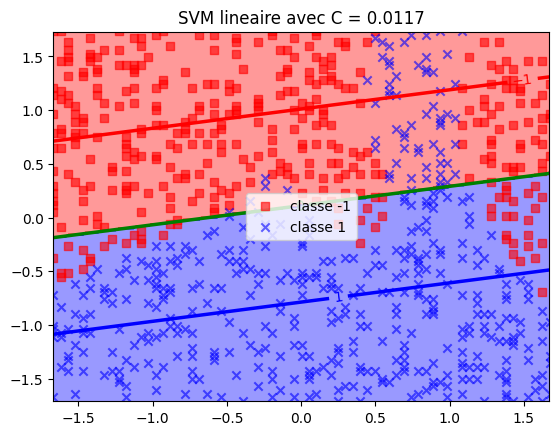

In [66]:
# definition du modele SVM Lineaire
paramC = 0.0117
clf_svm = SVC(kernel='linear', C = paramC)
# apprentissage des parametres du SVM Lineaire sur le jeu d'apprentissage
clf_svm.fit(Xa, Ya)

#%% Trace de la frontiere de decision et de la marge 
plot_decision_margin_2d(Xa, Ya, clf_svm, 0.02, titre='{} avec C = {}'.format("SVM lineaire", paramC))


#%% Erreur de classification en test du SVM Lineaire obtenu
err_app = 1 - accuracy_score(Ya, clf_svm.predict(Xa))
print('\nSVM Lineaire : erreur apprentissage = {}'.format(err_app))
err_test = 1 - accuracy_score(Yt, clf_svm.predict(Xt))
print('SVM Lineaire : erreur test = {}'.format(err_test))

/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],



SVM kernel : erreur apprentissage = 0.03749999999999998
SVM kernel : erreur test = 0.05970149253731338


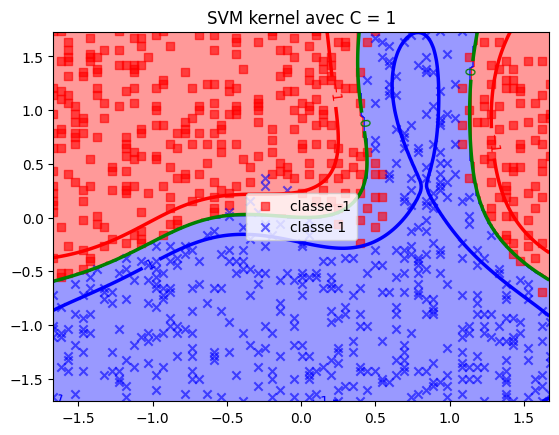

In [67]:
# Definition du modele SVM Non lineaire
paramC = 1
paramKer = 1
clf_ker = SVC(kernel='rbf', C = paramC, gamma=paramKer)
# apprentissage des parametres du SVM Lineaire sur le jeu d'apprentissage
clf_ker.fit(Xa, Ya)

# Trace de la frontiere de decision et de la marge 
plot_decision_margin_2d(Xa, Ya, clf_ker, 0.02, titre='{} avec C = {}'.format("SVM kernel", paramC))


# Erreur de classification en test du SVM Lineaire obtenu
err_app = 1 - accuracy_score(Ya, clf_ker.predict(Xa))
print('\nSVM kernel : erreur apprentissage = {}'.format(err_app))
err_test = 1 - accuracy_score(Yt, clf_ker.predict(Xt))
print('SVM kernel : erreur test = {}'.format(err_test))

Résumé des erreurs des deux modèles

| Erreur                | SVM kernel   | SVM Lineaire    |
|-----------------------|--------------|-----------------|
| erreur apprentissage  | 0.03         | 0.15            |
| erreur test           | 0.05         | 0.17            |

Comme le montre le tableau précédent, nous pouvons remarquer l'erreur sur les échantillons d'apprentissage et de test pour le modèle **SVM kernel** sont largement inférieurs aux erreurs pour le modèle **SVM Lineaire**. Cela se justifie par le fait que le modèle kernel qui n'est pas linéaire d'adapte beaucoup mieux aux données. La frontière des décisions montre que le modèle kernel, contrairement au modèle linéaire est en mesure de prendre en compte les observations de classe 1 mal classé par le modèle linéaire(Les observationns pouvant être séparés plutôt par des frontières verticales). Toutefois, comme pour tout modèle, il pourrait sans doute être améliorer en optimisant les hyperparamètres du modèle. 

## La frontière des décisions et marge en fonction du paramètre C

Pour différentes valeurs du paramètre C, on observera les frontières.

/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
/tmp/ipykernel_42/1105601916.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedenc

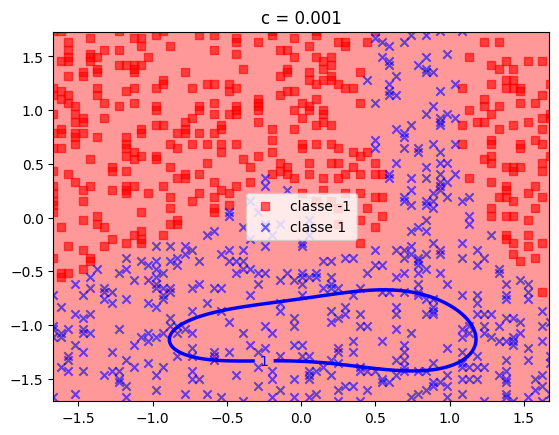

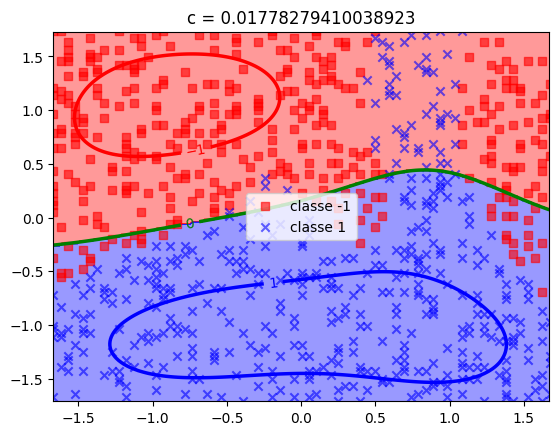

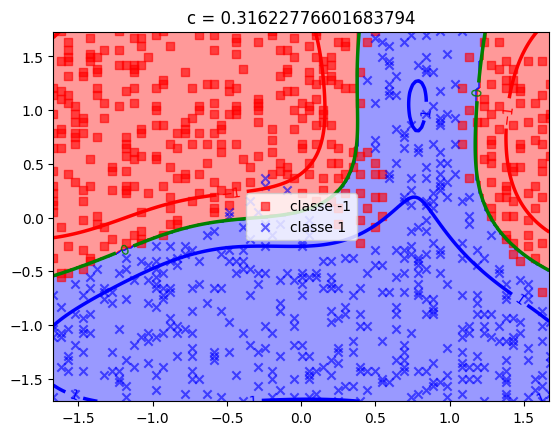

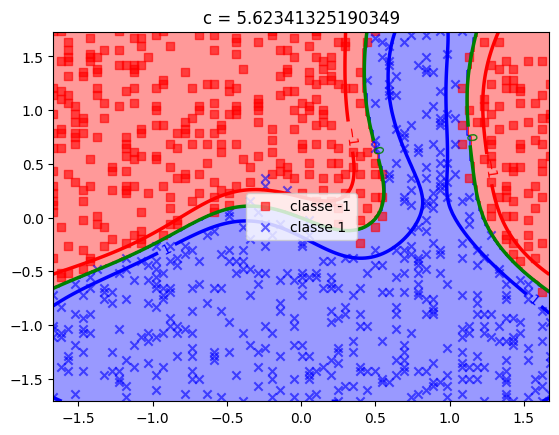

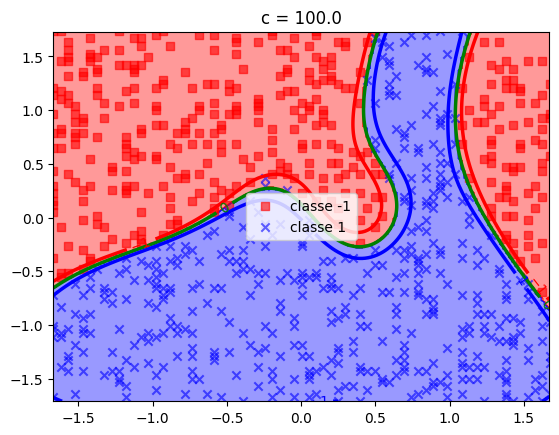

In [68]:
vectC = np.logspace(-3, 2, 5)
for paramC in vectC:
    clf_ker.C = paramC
    clf_ker.fit(Xa, Ya)
    plot_decision_margin_2d(Xa, Ya, clf_ker, 0.02, titre="c = {}".format(paramC))

Nous pouvons observé des changements importants des frontières de décision en fonction du paramètre C. En effet, plus **C** est grand, plus la fonction de décision s'ajuste aux données. On pourrait donc penser qu'une valeur très grande de **C**  pourrait entraîner un sur-ajustement aux données ce qui risque de ne pas pouvoir se généraliser correctement sur de nouvelles données. 

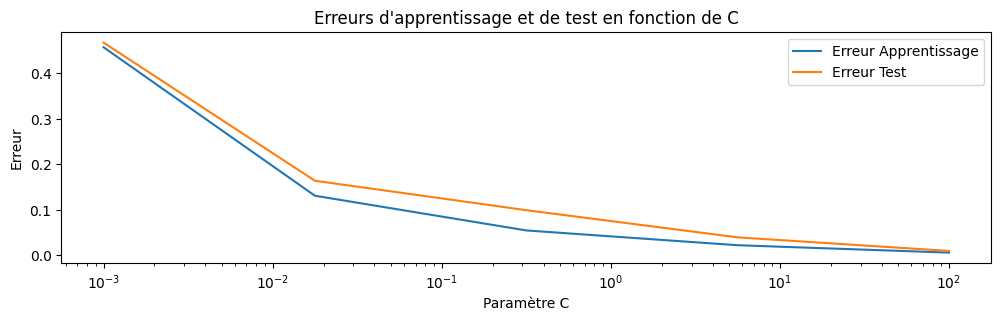

In [69]:
# Tableau des données
df_svm = pd.DataFrame(columns=['Paramètre C', 'Erreur Apprentissage', 'Erreur Test'])

# Valeurs de C
vectC = np.logspace(-3, 2, 5)

for parC in vectC:
    paramKer = 1
    clf_ker_C = SVC(kernel='rbf', C = parC, gamma=paramKer)
    
    clf_ker_C.fit(Xa, Ya)
    
    # Calculer les erreurs d'apprentissage et de test
    err_app_c = 1 - accuracy_score(Ya, clf_ker_C.predict(Xa))
    err_test_c = 1 - accuracy_score(Yt, clf_ker_C.predict(Xt))
    
    # Ajouter les résultats au DataFrame
    df_svm.loc[len(df_svm)] = [parC, err_app_c, err_test_c]

plt.figure(figsize=(12, 3))
plt.plot(df_svm['Paramètre C'], df_svm['Erreur Apprentissage'], label='Erreur Apprentissage')
plt.plot(df_svm['Paramètre C'], df_svm['Erreur Test'], label='Erreur Test')
plt.xscale('log')  # Mettre l'échelle de C en log
plt.xlabel('Paramètre C')
plt.ylabel('Erreur')
plt.title('Erreurs d\'apprentissage et de test en fonction de C')
plt.legend()
plt.show()

Ce graphique confirme la diminution de l'erreur lorsque C augmente.Il serait donc intéressant d'optimiser ce paralètre afin de choisir le bon.  

## La frontière des décisions et marge en fonction du paramètre `γ`

/tmp/ipykernel_42/734056071.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
/tmp/ipykernel_42/734056071.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
/tmp/ipykernel_42/734056071.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence i

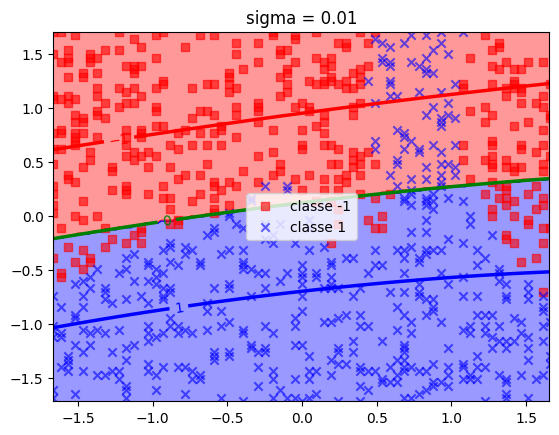

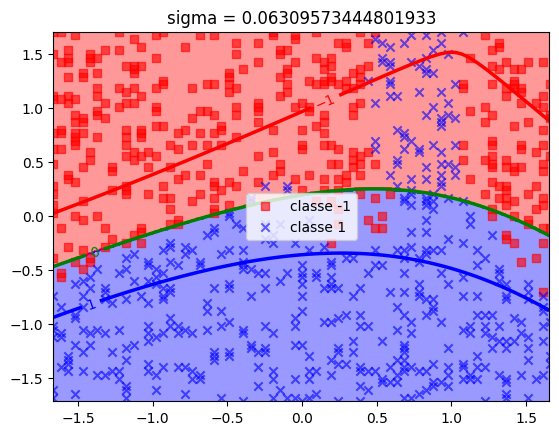

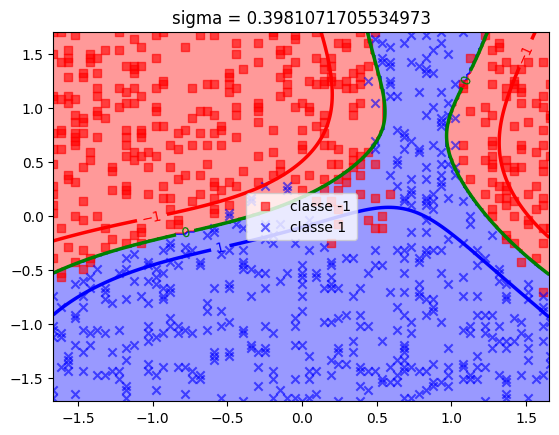

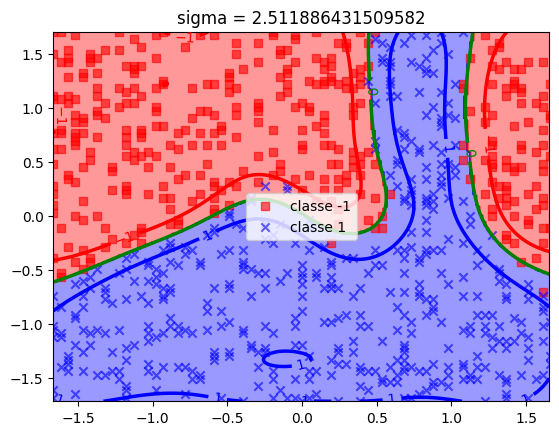

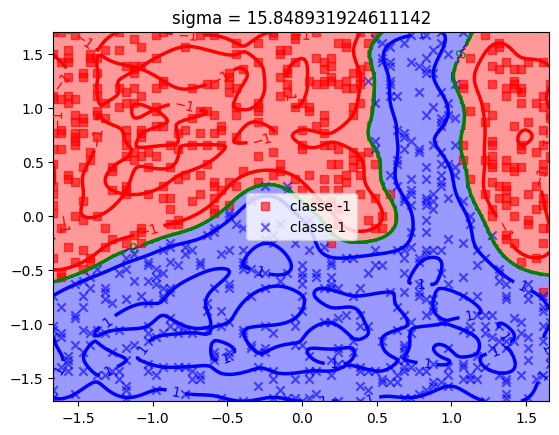

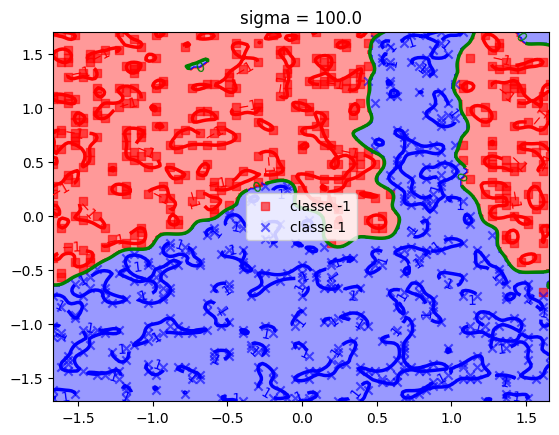

In [183]:
clf_ker.C = 1
vectGamma = np.logspace(-2, 2, 6)
for paramKer in vectGamma:
    clf_ker.gamma = paramKer
    clf_ker.fit(Xa, Ya)
    plot_decision_margin_2d(Xa, Ya, clf_ker, 0.02, titre="sigma = {}".format(paramKer))

Les différentes frontières de décision montrent l'importance du paramètre `γ` sur la frontière de décision. Pour une valeur très petite de ce paramètre (0,01), la frontière de décision est très proche du modèle SVM linéaire, ne pouvant pas prendre en compte les spécificités des données. Pour des valeurs très grande  de `γ`, le modèle est capable d'identifier des sous groupe de données ayant des caractéristiques similaires. L'optimisation de ce paramètre aura donc une grande importance dans la réduction des erreurs de notre modèle.

## Optimisation des paramètres `C` et `γ`

L’analyse des deux précédentes questions montre que la solution du SVM dépend des hyper-paramètres C et γ. Pour les sélectionner on réalise une recherche en grille (grid search) qui consiste à explorer des plages pré-définies des hyper-paramètres et pour chaque paire (C, γ ), on apprend le modèle SVM et on évalue ses performances sur les données de validation.

- Apprentissage du SVM pour C =  0.001 
	 Apprentissage du SVM pour gamma =   0.01 
	 Apprentissage du SVM pour gamma =   0.06 
	 Apprentissage du SVM pour gamma =   0.40 
	 Apprentissage du SVM pour gamma =   2.51 
	 Apprentissage du SVM pour gamma =  15.85 
	 Apprentissage du SVM pour gamma = 100.00 
- Apprentissage du SVM pour C =  0.010 
	 Apprentissage du SVM pour gamma =   0.01 
	 Apprentissage du SVM pour gamma =   0.06 
	 Apprentissage du SVM pour gamma =   0.40 
	 Apprentissage du SVM pour gamma =   2.51 
	 Apprentissage du SVM pour gamma =  15.85 
	 Apprentissage du SVM pour gamma = 100.00 
- Apprentissage du SVM pour C =  0.100 
	 Apprentissage du SVM pour gamma =   0.01 
	 Apprentissage du SVM pour gamma =   0.06 
	 Apprentissage du SVM pour gamma =   0.40 
	 Apprentissage du SVM pour gamma =   2.51 
	 Apprentissage du SVM pour gamma =  15.85 
	 Apprentissage du SVM pour gamma = 100.00 
- Apprentissage du SVM pour C =  1.000 
	 Apprentissage du SVM pour gamma =   0.01 
	 Ap

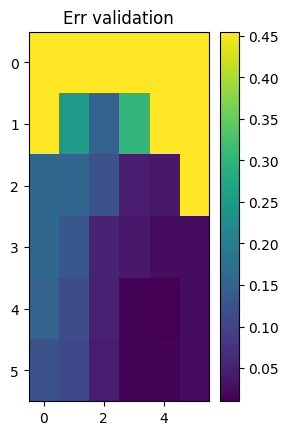

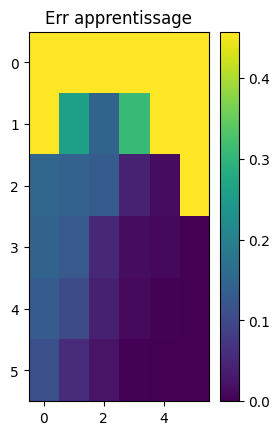

In [70]:
clf_ker = SVC(kernel = 'rbf')

vectC = np.logspace(-3, 2, 6)
vectGamma = np.logspace(-2, 2, 6)

err_val = np.empty((vectC.shape[0], vectGamma.shape[0]))
err_app = np.empty((vectC.shape[0], vectGamma.shape[0]))

for ind_C, C in enumerate(vectC):
    print("- Apprentissage du SVM pour C = {:6.3f} ".format(C))
    clf_ker.C = C
    for ind_gam, paramKer in enumerate(vectGamma):
        print("\t Apprentissage du SVM pour gamma = {:6.2f} ".format(paramKer))
        clf_ker.gamma = paramKer
        clf_ker.fit(Xa, Ya)
        err_val[ind_C, ind_gam] = 1 - accuracy_score(Yv, clf_ker.predict(Xv))
        err_app[ind_C, ind_gam] = 1 - accuracy_score(Ya, clf_ker.predict(Xa))


plt.subplot(121)
plt.imshow(err_val, aspect="auto")
plt.title("Err validation")
plt.colorbar()
plt.show()
plt.subplot(122)
plt.imshow(err_app, aspect="auto")
plt.title("Err apprentissage")
plt.colorbar()
plt.show()

Les deux graphiques présentent les erreurs de validation et d'apprentissage pour les différentes combinaisons de valeurs de C et γ. Les valeurs numériques de 0 à 5 sur l'axe des ordonnées (resp. absicsses) représentent les index des 6 valeurs différentes de C (resp. de γ). A l'intersection de ces deux éléments se trouve les erreurs de validation pour le premier graphique et l'erreur d'apprentissage pour le deuxième graphique. 

En analysant la heatmap de l'erreur de validation, on peut remarquer qu'elle est très proche de 0 voir nulle pour la valeur de C à l'index 5 et les valeurs de γ à l'index 3 et/ou 4. On serait donc tenter de penser que les paramètres optimaux pour C et γ sont respectivement 100 et 2,51 (ou 15,84)

- Les paramètres optimaux

In [71]:
ind_C, ind_gamma = np.unravel_index(np.argmin(err_val), err_val.shape)
Copt = vectC[ind_C]
GammaOpt = vectGamma[ind_gamma]
(Copt, GammaOpt)

(10.0, 15.848931924611142)

L'affichage des paramètres optimaux obtenus confirme les résultats de la heatmap. Le `C` optimal est de `100`. Quant à la valeur optimale de `γ`, elles est de `2.51`. 

## Ré-apprentissage du modèle

In [72]:
# Apprentissage modele optimal et evaluation
clf_ker.C = Copt
clf_ker.gamma = GammaOpt
clf_ker.fit(Xa, Ya)
err_app = 1 - accuracy_score(Ya, clf_ker.predict(Xa))
print("\nSVM kernel optimal : erreur apprentissage = {}%".format(err_app))
err_val = 1 - accuracy_score(Yv, clf_ker.predict(Xv))
print("SVM kernel optimal : erreur validation = {}%".format(err_val))
err_test = 1 - accuracy_score(Yt, clf_ker.predict(Xt))
print("SVM kernel optimal : erreur test = {}%".format(err_test))


SVM kernel optimal : erreur apprentissage = 0.0024999999999999467%
SVM kernel optimal : erreur validation = 0.010000000000000009%
SVM kernel optimal : erreur test = 0.01990049751243783%


Nous pouvons remarquer que les erreurs sont très faible pour les données pour les trois modèles. En effet, ce modèle s'ajuste beaucoup mieux aux données et permet d'avoir de meilleur performances

|Indicateur              | Modèle SVM Linéaire | Modèle SVM Non linéaire |
|------------------------|---------------------|-------------------------|
| Erreur Apprentissage   | 0.14                | 0.002                   |
| Erreur Validation      | 0.15                | 0.010                   |
| Erreur Test            | 0.17                | 0.020                   |

## SVM Polynomial

In [195]:
clf_poly = SVC(kernel='poly')

vectC = np.logspace(-3, 2, 2)
vectDegree = [2, 3]
vectGamma = np.logspace(-2, 2, 2)

err_val = np.zeros((len(vectC), len(vectDegree), len(vectGamma)))
err_app = np.zeros((len(vectC), len(vectDegree), len(vectGamma)))

for ind_C, C in enumerate(vectC):
    clf_poly.C = C
    for ind_degree, degree in enumerate(vectDegree):
        clf_poly.degree = degree
        for ind_gamma, paramGamma in enumerate(vectGamma):
            clf_poly.gamma = paramGamma
            clf_poly.fit(Xa, Ya)
            err_val[ind_C, ind_degree, ind_gamma] = 1 - accuracy_score(Yv, clf_ker.predict(Xv))
            err_app[ind_C, ind_degree, ind_gamma] = 1 - accuracy_score(Ya, clf_ker.predict(Xa))

In [198]:
ind_Copt, ind_degreeopt, ind_gammaopt = np.unravel_index(np.argmin(err_val), err_val.shape)
Copt = vectC[ind_C]
GammaOpt = vectGamma[ind_gamma]
DegreeOpt = vectDegree[ind_degreeopt]
(Copt, GammaOpt, DegreeOpt)

(100.0, 100.0, 2)

In [199]:
clf_poly_opt = SVC(kernel='poly', degree = DegreeOpt, C= Copt, gamma = GammaOpt)
clf_poly_opt.fit(Xa, Ya)
err_app_poly = 1 - accuracy_score(Ya, clf_poly_opt.predict(Xa))
print("\nSVM kernel optimal : erreur apprentissage = {}%".format(err_app_poly))
err_val_poly = 1 - accuracy_score(Yv, clf_poly_opt.predict(Xv))
print("SVM kernel optimal : erreur validation = {}%".format(err_val_poly))
err_test_poly = 1 - accuracy_score(Yt, clf_poly_opt.predict(Xt))
print("SVM kernel optimal : erreur test = {}%".format(err_test_poly))


SVM kernel optimal : erreur apprentissage = 0.36624999999999996%
SVM kernel optimal : erreur validation = 0.41500000000000004%
SVM kernel optimal : erreur test = 0.4328358208955224%


|Indicateur              | SVM Linéaire        | SVM Non linéaire        | SVM Polynomial |
|------------------------|---------------------|-------------------------|----------------|
| Erreur Apprentissage   | 0.14                | 0.002                   | 0.36           |
| Erreur Validation      | 0.15                | 0.010                   | 0.46           |
| Erreur Test            | 0.17                | 0.020                   | 0.41           |

Le tableau précédent montre les erreurs d'apprentissage, de validation et de test pour les trois modèles Linéaire,Non linéaire et Polynomial sur les données 

##  Extension du SVM non-linéaire aux données CTG

In [73]:
df = pd.read_csv("/kaggle/input/ctg-data/CTGSimple.csv", sep="\t",header=1)
Y = df["NSP"].values
variables = ["LB","AC.1","FM.1","UC.1","DL.1","DS.1","DP.1","ASTV","MSTV","ALTV","MLTV", "Width","Min","Max","Nmax", "Nzeros","Mode","Mean","Median","Variance","Tendency"]
X = df[variables].values
df.shape

# Regroupement en deux classes
classe = 3
Y[np.in1d(Y, classe)] = 2

# Echantillon d'apprentissage-Validation-Test
Xa, Xt, Ya, Yt = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y)
Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, shuffle=True, test_size = 0.2 / (1 - 0.2), stratify=Ya)

# Normalisation des données
sc = StandardScaler(with_mean=True, with_std=True)
sc = sc.fit(Xa)
Xa = sc.transform(Xa)
Xv = sc.transform(Xv)
Xt = sc.transform(Xt)

### Modèle SVM avec noyau gaussien sur CTGSimple.csv

In [74]:
ctg_ker = SVC(kernel='rbf', C = paramC, gamma=paramKer)

vectC = np.logspace(-3, 2, 6)
vectGamma = np.logspace(-2, 2, 6)
err_val = np.empty((vectC.shape[0], vectGamma.shape[0]))
err_app = np.empty((vectC.shape[0], vectGamma.shape[0]))

for ind_C, C in enumerate(vectC):
    ctg_ker.C = C
    for ind_gam, paramKer in enumerate(vectGamma):
        ctg_ker.gamma = paramKer
        ctg_ker.fit(Xa, Ya)
        err_val[ind_C, ind_gam] = 1 - accuracy_score(Yv, ctg_ker.predict(Xv))
        err_app[ind_C, ind_gam] = 1 - accuracy_score(Ya, ctg_ker.predict(Xa))

In [75]:
ind_C, ind_gamma = np.unravel_index(np.argmin(err_val), err_val.shape)
Copt = vectC[ind_C]
GammaOpt = vectGamma[ind_gamma]
(Copt, GammaOpt)

(100.0, 0.06309573444801933)

In [78]:
# Apprentissage modele optimal et evaluation
ctg_ker.C = Copt
ctg_ker.gamma = GammaOpt
ctg_ker.fit(Xa, Ya)
err_app = 1 - accuracy_score(Ya, ctg_ker.predict(Xa))
print("\nSVM kernel optimal : erreur apprentissage = {}%".format(100*err_app))
err_val = 1 - accuracy_score(Yv, ctg_ker.predict(Xv))
print("SVM kernel optimal : erreur validation = {}%".format(100*err_val))
err_test = 1 - accuracy_score(Yt, ctg_ker.predict(Xt))
print("SVM kernel optimal : erreur test = {}%".format(100*err_test))


SVM kernel optimal : erreur apprentissage = 0.23529411764705577%
SVM kernel optimal : erreur validation = 4.23529411764706%
SVM kernel optimal : erreur test = 5.39906103286385%


- Résumé modèle sur CTG

| Indicateur            | logistic | SVM Linéaire | SVM Non linéaire |
|-----------------------|----------|--------------|------------------|
|Erreur apprentissage   | 9.09     | 9.49         | 0.23             |
|Erreur validation      | 10.35    | 10.35        | 4.23             |
|Erreur test            | 9.85     | 10.56        | 5.40             |

En résumé, on peut remarquer que sur les données CGT, le modèle SVM Non linéaire donne de meilleur résultat. 

 # Pubs ou pas pubs
L’objectif est d’apprendre un modèle capable de classer automatiquement des blocks de vidéos apparaissant dans des programmes TV en deux catégories : vidéos commerciales ou vrais programmes
## Classification équilibrée ?

In [2]:
com_train = pd.read_csv("/kaggle/input/commercial/commercial_train.csv", header = None)
com_test = pd.read_csv("/kaggle/input/commercial/commercial_test.csv", header = None)

In [3]:
# Données Apprentissage
Ya = com_train.iloc[:,-1]
Xa = com_train.iloc[:, :-1]
# Données Test
Yt = com_test.iloc[:,-1]
Xt = com_test.iloc[:, :-1]

In [4]:
print('\nCaractéristiques jeu apprentissage : ')
print('Nombre de points : {}'.format(Xa.shape[0]))
print('Nombre de variables : {}'.format(Xa.shape[1]))
print('Nombre de classes : {}'.format(len(np.unique(Ya))))
classes, nbpoints = np.unique(Ya, return_counts=True)
for i, lab in enumerate(classes):
    print('Classe {} comprend {} points'.format(lab, nbpoints[i]))


Caractéristiques jeu apprentissage : 
Nombre de points : 8525
Nombre de variables : 122
Nombre de classes : 2
Classe -1.0 comprend 2243 points
Classe 1.0 comprend 6282 points


In [5]:
print('\nCaractéristiques jeu de test : ')
classes, nbpoints = np.unique(Yt, return_counts=True)
for i, lab in enumerate(classes):
    print('Classe {} comprend {} points'.format(lab, nbpoints[i]))


Caractéristiques jeu de test : 
Classe -1.0 comprend 2244 points
Classe 1.0 comprend 6282 points


Nous pouvons remarquer qu'aussi bien dans la base de donnée d'apprentissage et de test, la classe 1 (pub) contiennent plus d'éléments que la classe des non pubs. On ne peut donc pas considéré qu'il s'agit d'un problème de classification est équilibré. 

## Analyse des features
### Fundamental Frequency

In [6]:
index_fund_freq = np.arange(15, 17)
Xa_fund_freq = Xa.iloc[:,index_fund_freq]
Xt_fund_freq = Xt.iloc[:,index_fund_freq]

In [7]:
sc = StandardScaler(with_mean = True, with_std = True)
sc = sc.fit(Xa_fund_freq)
Xa_fund_freq = sc.transform(Xa_fund_freq)
Xt_fund_freq = sc.transform(Xt_fund_freq)

logistic_fund_freq = linear_model.LogisticRegression(tol=1e-5, multi_class='multinomial', solver='lbfgs')
vectC = np.logspace(-5, 5, 15)
err_app = np.zeros(vectC.shape[0])
err_test = np.zeros(vectC.shape[0])

for ind_C, C in enumerate(vectC):
    logistic_fund_freq.C = C
    logistic_fund_freq.fit(Xa_fund_freq, Ya)
    err_test[ind_C] = 1 - accuracy_score(Yt, logistic_fund_freq.predict(Xt_fund_freq))
    err_app[ind_C] = 1 - accuracy_score(Ya, logistic_fund_freq.predict(Xa_fund_freq))

# Choix du meilleur C
err_min_test, ind_min = err_test.min(), err_test.argmin()
Copt_fund_freq = vectC[ind_min]

In [8]:
logistic_fund_freq.C = Copt_fund_freq
logistic_fund_freq.fit(Xa_fund_freq, Ya)
print('Valeur de Copt = {}'.format(Copt_fund_freq))
print('Err test correspondante = {}'.format(100*(1 - accuracy_score(Yt, logistic_fund_freq.predict(Xt_fund_freq)))))
print('Err apprentissage correspondante = {}'.format(100*(1 - accuracy_score(Ya, logistic_fund_freq.predict(Xa_fund_freq)))))


Valeur de Copt = 0.0013894954943731376
Err test correspondante = 20.513722730471496
Err apprentissage correspondante = 21.24340175953079


### Frame difference distribution

In [9]:
index_fr_dif_dist = np.arange(58, 91)
Xa_fr_dif_dist = Xa.iloc[:,index_fr_dif_dist]
Xt_fr_dif_dist = Xt.iloc[:,index_fr_dif_dist]

sc = StandardScaler(with_mean = True, with_std = True)
sc = sc.fit(Xa_fr_dif_dist)
Xa_fr_dif_dist = sc.transform(Xa_fr_dif_dist)
Xt_fr_dif_dist = sc.transform(Xt_fr_dif_dist)

In [10]:
logistic_fr_dif_dist = linear_model.LogisticRegression(tol=1e-5, multi_class='multinomial', solver='lbfgs')
vectC = np.logspace(-3, 2, 10)
err_test_fr_dif_dist = np.zeros(vectC.shape[0])
err_app_fr_dif_dist = np.zeros(vectC.shape[0])

for ind_C, C in enumerate(vectC):
    logistic_fr_dif_dist.C = C
    logistic_fr_dif_dist.fit(Xa_fr_dif_dist, Ya)
    err_test_fr_dif_dist[ind_C] = 1 - accuracy_score(Yt, logistic_fr_dif_dist.predict(Xt_fr_dif_dist))
    err_app_fr_dif_dist[ind_C] = 1 - accuracy_score(Ya, logistic_fr_dif_dist.predict(Xa_fr_dif_dist))

# Choix du meilleur C
err_min_test, ind_min = err_test_fr_dif_dist.min(), err_test_fr_dif_dist.argmin()

Copt_fr_dif_dist = vectC[ind_min]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [11]:
logistic_fr_dif_dist.C = Copt_fr_dif_dist
logistic_fr_dif_dist.fit(Xa_fr_dif_dist, Ya)
print('Valeur de Copt = {}'.format(Copt_fr_dif_dist))
print('Err test correspondante = {}'.format(100*(1 - accuracy_score(Yt, logistic_fr_dif_dist.predict(Xt_fr_dif_dist)))))
print('Err apprentissage correspondante = {}'.format(100*(1 - accuracy_score(Ya, logistic_fr_dif_dist.predict(Xa_fr_dif_dist)))))

Valeur de Copt = 0.5994842503189408
Err test correspondante = 22.789115646258505
Err apprentissage correspondante = 23.46041055718475


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Test area 

In [12]:
index_area_dist = np.arange(91, 122)
Xa_area_dist = Xa.iloc[:,index_area_dist]
Xt_area_dist = Xt.iloc[:,index_area_dist]

In [13]:
sc = StandardScaler(with_mean = True, with_std = True)
sc = sc.fit(Xa_area_dist)
Xa_area_dist = sc.transform(Xa_area_dist)
Xt_area_dist = sc.transform(Xt_area_dist)

logistic_area_dist = linear_model.LogisticRegression(tol=1e-5, multi_class='multinomial', solver='lbfgs')
vectC = np.logspace(-5, 5, 15)
err_test_area = np.zeros(vectC.shape[0])
err_app_area = np.zeros(vectC.shape[0])

for ind_C, C in enumerate(vectC):
    logistic_area_dist.C = C
    logistic_area_dist.fit(Xa_area_dist, Ya)
    err_test_area[ind_C] = 1 - accuracy_score(Yt, logistic_area_dist.predict(Xt_area_dist))
    err_app_area[ind_C] = 1 - accuracy_score(Ya, logistic_area_dist.predict(Xa_area_dist))
    
# Choix du meilleur C
err_min_test, ind_min = err_test.min(), err_test.argmin()
Copt_area_dist = vectC[ind_min]

In [14]:
logistic_area_dist.C = Copt_area_dist
logistic_area_dist.fit(Xa_area_dist, Ya)
print('Valeur de Copt = {}'.format(Copt_area_dist))
print('Err test correspondante = {}'.format(100*(1 - accuracy_score(Yt, logistic_area_dist.predict(Xt_area_dist)))))
print('Err apprentissage correspondante = {}'.format(100*(1 - accuracy_score(Ya, logistic_area_dist.predict(Xa_area_dist)))))

Valeur de Copt = 0.0013894954943731376
Err test correspondante = 15.188834154351394
Err apprentissage correspondante = 14.59237536656891


### Résumé des modèles logistiques sur features

Le tableau suivant présente le résumé des erreurs obtenus sur les échantillons d'apprentissage et de test pour les trois type de features

|Features                | Erreur Apprentissage | Erreur Test | 
|-----------------------|----------------------|-------------|
|Fundamental Frequency  |      21.24           | 20.51       |
|Frame Difference Distribution | 23.46         |22.78        |
|Text area distribution | 14,59                |15.18        |


De son analyse, on peut remarqué que les features qui donnent les meilleurs résultats est la répartition de la zone de texte(Text area distribution). Il a l'erreur le plus faible, aussi bien sur l'échantillon d'apprentissage que sur l'échantillon de test. Cet indicateur est donc le plus capable de distinguer les deux classes de vidéos. On pourrait donc logiquement penser que l'aire de distribution du test est plus réduit dans les publicités que dans les vrais programmes TV.

## Modèle SVM non linéaire avec un noyau gaussien 

Les features considérés seront ceux de la répartition de la zone de test. Il s'agit donc de Xa_area_dist et Xt_area_dist. 

In [17]:
svm_pub = SVC(kernel='rbf')

vectC = np.logspace(-3, 2, 6)
vectGamma = np.logspace(-2, 2, 6)
err_app = np.zeros((vectC.shape[0], vectGamma.shape[0]))
err_test = np.zeros((vectC.shape[0], vectGamma.shape[0]))

for ind_C, C in enumerate(vectC):
    svm_pub.C = C
    for ind_gam, paramKer in enumerate(vectGamma):
        svm_pub.gamma = paramKer
        svm_pub.fit(Xa_area_dist, Ya)
        err_app[ind_C, ind_gam] = 1 - accuracy_score(Ya, svm_pub.predict(Xa_area_dist))
        err_test[ind_C, ind_gam] = 1 - accuracy_score(Yt, svm_pub.predict(Xt_area_dist))

In [19]:
ind_C, ind_gamma = np.unravel_index(np.argmin(err_test), err_test.shape)
Copt = vectC[ind_C]
GammaOpt = vectGamma[ind_gamma]
(Copt, GammaOpt)

(100.0, 0.01)

### Comparaison des performances
#### Précision

In [21]:
svm_pub.C = Copt
svm_pub.gamma = GammaOpt
svm_pub.fit(Xa_area_dist, Ya)
err_apprentissage = 1 - accuracy_score(Ya, svm_pub.predict(Xa_area_dist))
print("\nSVM kernel optimal : erreur apprentissage = {}%".format(100*err_apprentissage))
err_test_ech = 1 - accuracy_score(Yt, svm_pub.predict(Xt_area_dist))
print("SVM kernel optimal : erreur validation = {}%".format(100*err_test_ech))


SVM kernel optimal : erreur apprentissage = 2.404692082111437%
SVM kernel optimal : erreur validation = 5.442176870748295%


#### Matrice de confusion
Sur le modèle SVM

Text(0, 0.5, 'Vrai label')

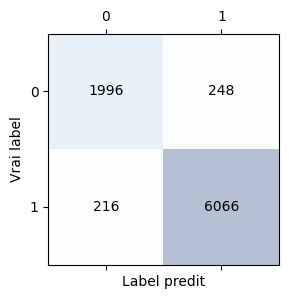

In [22]:
yt_svm = svm_pub.predict(Xt_area_dist)
confmat = confusion_matrix(y_true=Yt, y_pred=yt_svm)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
plt.xlabel("Label predit")
plt.ylabel("Vrai label")

Modèle logistic

Text(0, 0.5, 'Vrai label')

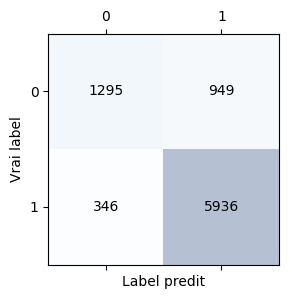

In [23]:
yt_logistic = logistic_area_dist.predict(Xt_area_dist)
confmat2 = confusion_matrix(y_true=Yt, y_pred=yt_logistic)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat2, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat2.shape[0]):
    for j in range(confmat2.shape[1]):
        ax.text(x=j, y=i, s=confmat2[i, j], va="center", ha="center")
plt.xlabel("Label predit")
plt.ylabel("Vrai label")

- Résumes sur le text area distribution

| Indicateurs           | Logistique    | SVM Non linéaire  |
|-----------------------|---------------|-------------------|
| Erreur apprentisage   | 14.59         | 2.40              |
| Erreur Test           | 15.18         | 5.44              |


On peut observer que le modèle SVN Non linéaire donne de meilleur résultat que le modèle logistique. Ce modèle ainsi que les features de l'aire de distribution du test permettent de bien classé les vidéos.